<a href="https://colab.research.google.com/github/perrin-isir/xomx-tutorials/blob/main/tutorials/xomx_tcr.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>
<a id="raw-url" href="https://raw.githubusercontent.com/perrin-isir/xomx-tutorials/main/tutorials/xomx_tcr.ipynb" download> <img align="left" src="https://img.shields.io/badge/Github-Download%20(Right%20click%20%2B%20Save%20link%20as...)-blue" alt="Download (Right click + Save link as)" title="Download Notebook"></a>

# *xomx tutorial:* **predicting TCR-epitope binding**

In this tutorial, we train an extra-trees classifier to predict whether a TCR $\beta$-chain CDR3 sequence is associated with a given epitope. The classifier takes in input a one-hot encoding of the CDR3 sequence. 

We use data taken from the [VDJdb](https://vdjdb.cdr3.net/) and [MsPAS-TCR](http://friedmanlab.weizmann.ac.il/McPAS-TCR/) databases.

Here is the figure obtained at the end of this tutorial (using the Logomaker library), which, for the peptide GILGFVFTL (influenza M1 protein), compares distributions of predicted binding CDR3 sequences (on the left) to true distributions of binding CDR3 sequences derived from the data (on the right):

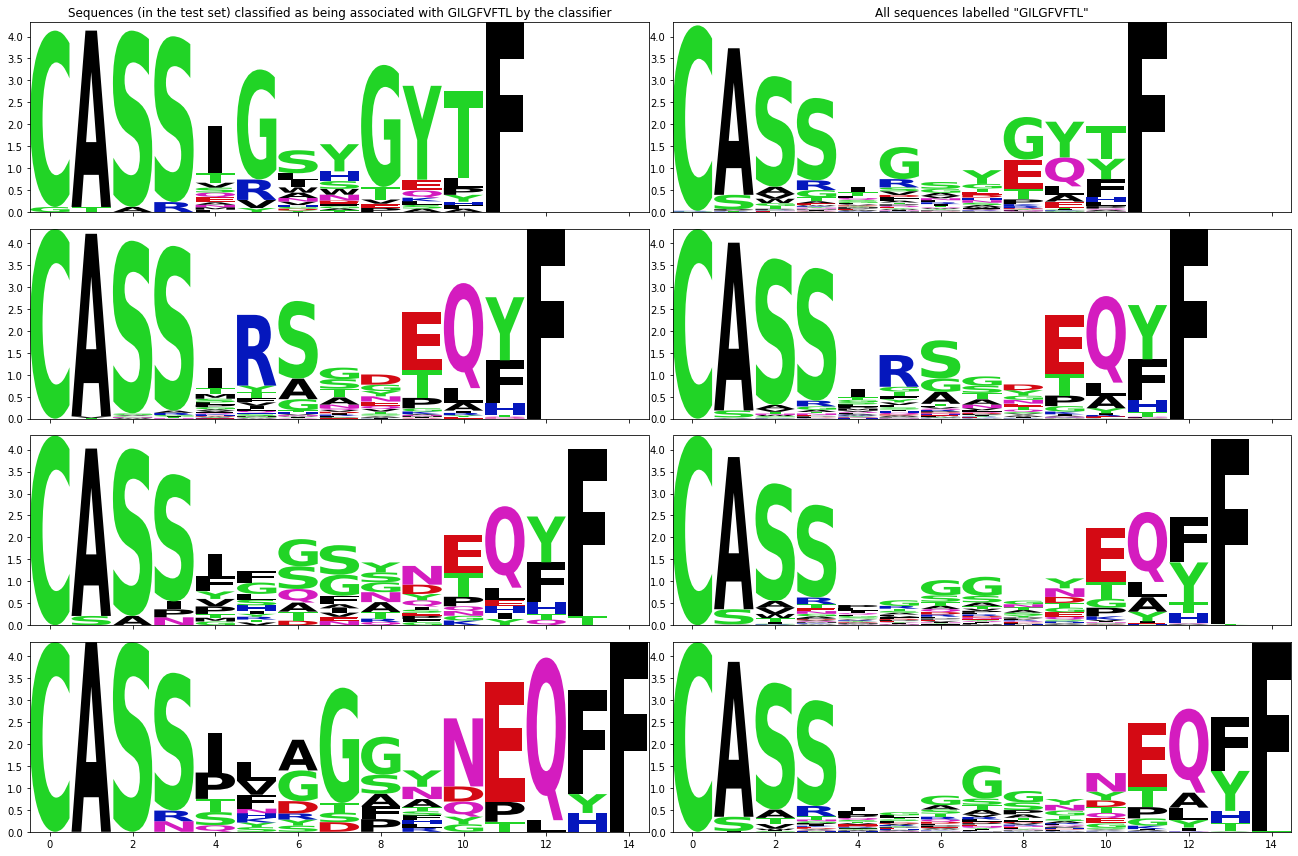

In [ ]:
# import matplotlib
import os
import matplotlib
from IPython import get_ipython
if 'google.colab' in str(get_ipython()):
    # upgrade matplotlib to avoid errors with the default version in Colab 
    !pip install --upgrade matplotlib
import matplotlib.pyplot as plt

In [ ]:
# other imports:
import sys
import joblib
from IPython import embed
from IPython.display import clear_output
try:
    import xomx
except ImportError:
    !pip install xomx
    clear_output()
    import xomx
try:
    import scanpy as sc
except ImportError:
    !pip install scanpy==1.9.8
    clear_output()
    import scanpy as sc
try:
    import logomaker
except ImportError:
    !pip install logomaker
    clear_output()
    import logomaker
import umap
import pandas as pd
import numpy as np

# Enable bokeh outputs in notebooks:
from bokeh.io import output_notebook
def outbook():
    ipython_string = str(get_ipython())
    if "google.colab" in ipython_string or "ipykernel" in ipython_string:
        output_notebook()
outbook()

# Give the possibility to force a plotting extension (bokeh or matplotlib) when running the code as a python script:
if len(sys.argv) > 1 and sys.argv[1] in ["bokeh", "matplotlib"]:
    xomx.pl.force_extension(sys.argv[1])

We first define `save_dir`, the folder in which everything will be saved.

In [ ]:
save_dir = os.path.join(os.path.expanduser("~"), "results", "xomx-tutorials", "xomx_tcr")
os.makedirs(save_dir, exist_ok=True)

We import both the VDJdb and the MsPAS-TCR databases.

For the McPAS-TCR database, a link must be provided. Please go to [http://friedmanlab.weizmann.ac.il/McPAS-TCR/](http://friedmanlab.weizmann.ac.il/McPAS-TCR/), 
right-click "Copy link adress" on the "Download the complete database..." button, and paste the url in the input prompt.

In [ ]:
vdjdb_file = "vdjdb-2021-09-05.zip"
vdjdb_url = os.path.join("https://github.com/antigenomics/vdjdb-db/releases/download/2021-09-05/", vdjdb_file)
mcpas_tcr_file = "McPAS-TCR.csv"

if not os.path.isfile(os.path.join(save_dir, "vdjdb_full.txt")):
    !wget {vdjdb_url} --directory-prefix={save_dir}
    !unzip {os.path.join(save_dir, vdjdb_file)} -d {save_dir}

if not os.path.isfile(os.path.join(save_dir, mcpas_tcr_file)):
    mcpas_tcr_url = input("Please go to http://friedmanlab.weizmann.ac.il/McPAS-TCR/, right-click 'Copy link adress' on the 'Download the complete database...' button, and paste the url here:\n")
    assert mcpas_tcr_url != "", "Please provide the link address for the McPAS-TCR database."
    !wget {mcpas_tcr_url} --output-document={os.path.join(save_dir, mcpas_tcr_file)}

We convert the VDJdb and the MsPAS-TCR databases to pandas DataFrames, go through these dataframes, and construct two dictionnaries:  
`dic_cdr3beta` and `dic_epitopes`. 

For every $\beta$-chain CDR3 sequence `s`, `dic_cdr3beta[s]` is the set of epitopes to which it is associated.  
For every epitope sequence `s`, `dic_epitopes[s]` is the set of $\beta$-chain CDR3 sequences to which it is associated.

**Remark: we only take into account CDR3 sequences of length at most 22 (arbitrary choice).**

In [ ]:
dic_epitopes_file = "dic_epitopes.joblib"
dic_cdr3beta_file = "dic_cdr3beta.joblib"
cdr3_max_length = 22

if not os.path.isfile(os.path.join(save_dir, dic_epitopes_file)) or not os.path.isfile(os.path.join(save_dir, dic_cdr3beta_file)):
    vdjdb_df = pd.read_csv(os.path.join(save_dir, "vdjdb_full.txt"), delimiter="\t", low_memory=False)
    mcpas_tcr_df = pd.read_csv(os.path.join(save_dir, "McPAS-TCR.csv"), encoding="cp1252", delimiter=",", low_memory=False)

    dic_cdr3beta = {}
    dic_epitopes = {}

    def dic_iteration(cdr3beta_seq, epitope_seq):
        if cdr3beta_seq == cdr3beta_seq and epitope_seq == epitope_seq:  # filter NaNs
            if not set(epitope_seq).difference(xomx.tl.aminoacids) and not set(cdr3beta_seq).difference(xomx.tl.aminoacids):  #filter undefined symbols
                if len(cdr3beta_seq) <= cdr3_max_length:  # filter long sequences
                    dic_cdr3beta.setdefault(cdr3beta_seq, set())
                    dic_cdr3beta[cdr3beta_seq].add(epitope_seq)
                    dic_epitopes.setdefault(epitope_seq, set())
                    dic_epitopes[epitope_seq].add(cdr3beta_seq)

    for i in range(len(vdjdb_df)):
        cdr3beta = vdjdb_df["cdr3.beta"].values[i]
        epitope = vdjdb_df["antigen.epitope"].values[i]
        dic_iteration(cdr3beta, epitope)

    for i in range(len(mcpas_tcr_df)):
        cdr3beta = mcpas_tcr_df["CDR3.beta.aa"].values[i]
        epitope = mcpas_tcr_df["Epitope.peptide"].values[i]
        dic_iteration(cdr3beta, epitope)
    
    joblib.dump(dic_epitopes, os.path.join(save_dir, dic_epitopes_file))
    joblib.dump(dic_cdr3beta, os.path.join(save_dir, dic_cdr3beta_file))
else:
    dic_epitopes = joblib.load(os.path.join(save_dir, dic_epitopes_file))
    dic_cdr3beta = joblib.load(os.path.join(save_dir, dic_cdr3beta_file))

In [ ]:
print(f"{len(dic_cdr3beta)} beta-chain CDR3 sequences in total")
cdr3_single_epitope = set()
for key, value in dic_cdr3beta.items():
    if len(value) == 1:
        cdr3_single_epitope.add(key)
print(f"{len(cdr3_single_epitope)} beta-chain CDR3 sequences associated to a unique epitope")

Optionally, we recompute `dic_epitopes` to keep only CDR3 beta sequences that are associated to a unique epitope:

In [ ]:
dic_epitopes= {}
for key in dic_cdr3beta:
    if len(dic_cdr3beta[key]) == 1:
        epitope = list(dic_cdr3beta[key])[0]
        dic_epitopes.setdefault(epitope, set())
        dic_epitopes[epitope].add(key)
        assert(key in cdr3_single_epitope)

We sort the epitopes by decreasing number of associated beta-chain CDR3 sequences:

In [ ]:
sorted_epitopes = sorted(dic_epitopes, key=lambda k: len(dic_epitopes[k]), reverse=True)

We use one-hot encodings to represent the CDR3 sequences. Their dimension is `cdr3_max_length` x `len(xomx.tl.aminoacids)`, where `xomx.tl.aminoacids` is the list of the 20 standard amino acid characters:

In [ ]:
dimension = cdr3_max_length * len(xomx.tl.aminoacids)
dimension

We construct annotated data with the one-hot encodings of the beta-chain CDR3 sequences corresponding to the `K=30` most frequent epitopes.

In [ ]:
K = 30
nr_samples = sum([len(dic_epitopes[sorted_epitopes[j]]) for j in range(K)])
nr_samples

In [ ]:
xd = sc.AnnData(shape=(nr_samples, dimension))
xd.obs_names = np.hstack([sorted(list(dic_epitopes[sorted_epitopes[j]])) for j in range(K)])
xd.obs["labels"] = np.hstack([[sorted_epitopes[j]] * len(dic_epitopes[sorted_epitopes[j]]) for j in range(K)])
xd.uns["all_labels"] = xomx.tl.all_labels(xd.obs["labels"])
xd.uns["obs_indices_per_label"] = xomx.tl.indices_per_label(xd.obs["labels"])
xd.X = np.zeros((xd.n_obs, xd.n_vars))
for i in range(xd.n_obs):
    xd.X[i, :] = xomx.tl.onehot(xd.obs_names[i], cdr3_max_length)

We randomly separate the sequences into a training (75%) and a test set (25%):

In [ ]:
rng = np.random.RandomState(0)
xomx.tl.train_and_test_indices(xd, "obs_indices_per_label", test_train_ratio=0.25, rng=rng)

A UMAP plot based on 4000 randomly chosen sequences:

In [ ]:
xd.obsm["umap"] = umap.UMAP().fit_transform(xd.X)

In [ ]:
tmp_rng = np.random.RandomState(42)
subset_test_indices = xd.uns["test_indices"][tmp_rng.choice(len(xd.uns["test_indices"]), 5000, replace=False)]
xomx.pl.plot_2d_obsm(xd, "umap", subset_indices=subset_test_indices, height=750)

In [ ]:
classifier = {}

In [ ]:
xd.uns["all_labels"][:10]

We define a binary classifier for the epitope GILGFVFTL:

In [ ]:
index = 2  # index of GILGFVFTL
classifier[xd.uns["all_labels"][index]] = xomx.cl.ExtraTrees(
    xd,
    xd.uns["all_labels"][index],
    n_estimators=450,
    random_state=rng,
)

The `xomx.cl.ExtraTrees()` class uses the Extra-Trees algorithm to train binary classifiers 
to discriminate between a reference label and the rest.

Here, the classifier is trained to discriminate between beta-chain CDR3 sequences associated to GILGFVFTL, and other beta-chain CDR3 sequences:

In [ ]:
classifier[xd.uns["all_labels"][index]].train()

We plot the result of the classifier on 6000 random samples from the test set (points above the red line are classified as being associated with GILGFVFTL):

In [ ]:
tmp_rng = np.random.RandomState(42)
classifier[xd.uns["all_labels"][index]].plot(random_subset_size=5000, rng=tmp_rng, height=750)

We compute the Matthews Correlation Coefficient on the test set:

In [ ]:
xomx.tl.matthews_coef(classifier[xd.uns["all_labels"][index]].confusion_matrix)

We gather the predictions on the test set (`True` means that classifier considers the sequence to be GILGFVFTL-related) in an array:

In [ ]:
predictions_on_test_set = (classifier[xd.uns["all_labels"][index]].predict(xd.X[xd.uns["test_indices"]]) == 1)

We define `ok_samples_test_set`, the indices of the beta-chain CDR3 sequences in the test set that are classified as being associated with GILGFVFTL by the classifier:

In [ ]:
ok_samples_test_set = [xd.uns["test_indices"][j] for j, val in enumerate(predictions_on_test_set) if val]

We also define `all_GILGFVFTL_samples`, the indices of all the sequences labelled "GILGFVFTL":

In [ ]:
all_GILGFVFTL_samples = xd.uns["obs_indices_per_label"]["GILGFVFTL"]

We can now plot the logo computed from all these beta-chain CDR3 sequences, using logomaker. The function `xomx.tl.compute_logomaker_df()` computes the pandas DataFrame required by logomaker (a table of probabilities for all characters and positions).

In [ ]:
df_logo = xomx.tl.compute_logomaker_df(xd, all_GILGFVFTL_samples)
_, ax = plt.subplots(figsize=[12, 3])
logo = logomaker.Logo(df_logo, ax=ax)
plt.show()

Logos obtained from sequences of variable lengths are not ideal for interpretation, so in `xomx.tl.compute_logomaker_df()` we can use the option `fixed_length` to 
compute distinct logos for various lengths.

Below, we compute logos for sequences of length 12, 13, 14 and 15. We compare the logos computed from `ok_samples_test_set` (column on the left), and `all_GILGFVFTL_samples` (column on the right):

In [ ]:
df_logo_fixed_length = {}
lengths = np.arange(12, 16)
fig, ax = plt.subplots(len(lengths), 2, figsize=[18, 3 * len(lengths)], sharex=True)
ax[0, 0].set_title("Sequences (in the test set) classified as being associated with GILGFVFTL by the classifier")
ax[0, 1].set_title('All sequences labelled "GILGFVFTL"')
for i in lengths:   
    logomaker.Logo(xomx.tl.compute_logomaker_df(xd, ok_samples_test_set, fixed_length=i), 
                          ax=ax[i - lengths[0], 0])
    logomaker.Logo(xomx.tl.compute_logomaker_df(xd, all_GILGFVFTL_samples, fixed_length=i), 
                          ax=ax[i - lengths[0], 1])
fig.tight_layout()
plt.show()

Remark: you can train classifiers on other epitopes than GILGFVFTL, but not all the epitopes lead to classifiers that perform relatively well on the test set. For some epitopes, after the training, results on the test set are not better than random predictions. The complexity of the patterns associated with an epitope may vary greatly depending on the epitope.

For more complete results with similar classifiers, you can visit the TCRex web tool page: https://tcrex.biodatamining.be/home/.